# closed form solution

optimization has no closed form solution for general loss function, but has closed form solution for GLM, linear regression, logitistic regression

| Model             | Empirical Risk ($R(\beta)$) | Gradient ($\nabla R(\beta)$) | Hessian ($\nabla^2 R(\beta)$) |
|-------------------|-----------------------------|-------------------------------|-------------------------------|
| GLM               | $\frac{1}{n}\sum_{i=1}^n A(\left \langle \mathbf{x_i},\beta \right \rangle) - \mathbf{y_i}\left \langle \mathbf{x_i},\beta \right \rangle - \ln(h(\mathbf{y_i}))$ | $\frac{1}{n}\mathbf{X}^T(\boldsymbol{\mu}-\mathbf{y})$<br>$\frac{1}{n}\sum_{i=1}^n \left[A'(\left \langle \mathbf{x_i},\beta \right \rangle) - \mathbf{y_i}\right]\mathbf{x_i}$| $\frac{1}{n}\mathbf{X}^T\boldsymbol{\Sigma}\mathbf{X}$ <br>$\frac{1}{n}\sum_{i=1}^nA''(\left \langle \mathbf{x_i},\beta \right \rangle)\mathbf{x_i}\mathbf{x_i}^T$|
| Linear Regression  | $\frac{1}{2n}\left\|\mathbf{X}\beta-\mathbf{y}\right\|^2$<br>$\frac{1}{2n}\sum_{i=1}^n(\mathbf{x_i}^T\beta -\mathbf{y_i})^2$                      | $\frac{1}{n}\mathbf{X}^T(\mathbf{X}\beta-\mathbf{y})$ <br> $\frac{1}{n}\sum_{i=1}^n\left(\mathbf{x_i}^T\beta-\mathbf{y_i}\right)\mathbf{x_i}$ | $\frac{1}{n}\mathbf{X}^T\mathbf{X}$<br>$\frac{1}{n}\sum_{i=1}^n\mathbf{x_i}\mathbf{x_i}^T$ |
| Logistic Regression $y\in \left\{0, 1\right\}$| $-\frac{1}{n}\sum_{i=1}^n \mathbf{y_i}\ln(\mathbf{p}_i) + (1-\mathbf{y_i})\ln(1-\mathbf{p}_i)$ | $\frac{1}{n}\mathbf{X}^T(\mathbf{p}-\mathbf{y})$<br>$\frac{1}{2n}\sum_{i=1}^n(\mathbf{p_i} -\mathbf{y_i})^2$ | $\frac{1}{n}\mathbf{X}^T\boldsymbol{S}\mathbf{X}$<br>$\frac{1}{n}\sum_{i=1}^n\mathbf{p_i}(1-\mathbf{p_i})\mathbf{x_i}\mathbf{x_i}^T$  |


$\mathbf{\mu}=A'(\left \langle \mathbf{X},\beta \right \rangle)$, $\boldsymbol{\Sigma}=A''(\left \langle \mathbf{X},\beta \right \rangle)$

$\mathbf{p}=P(\mathbf{y}=1|X)=\frac{1}{1+e^{-X^T\beta}}$, $\boldsymbol{S}=\text{diag}[\mathbf{p}(1-\mathbf{p})]$

# implementation

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt 


def gradientDescent(type: str):
    """Implementation of 3 types of gradient descent (Batch, Newton's, stochastic)
       Plot 4 subplots: 
       1. Optimization error vs. runtime, 
       2. Optimization error vs. iteration times
       3. Statistical error vs. runtime,
       4. Statistical error vs. iteration times

       type: 'linear' or 'logistic'
    """
    n=1000 # sample size

    p=10 # number of feature

    # Singular Value Decomposition of p*p matrix
    u,s,v = np.linalg.svd(np.random.randn(p,p))

    # input n*p matrix
    X = np.random.randn(n,p) @ (u*(2./np.sqrt(np.arange(1,p+1)))) @ u.T

    # true beta p*1 vector
    betastar = np.random.randn(p)

    # response
    if type == 'linear':
        y = X @ betastar + np.random.randn(n)
    elif type == 'logistic':
        y = np.random.rand(n) < 1/(1 + np.exp(- X @ betastar))

    # hyperparameters
    eta = 0.1       # step size
    epoch = 100     # number of iterations

    # store guesses of beta
    B_batch = np.zeros((epoch,p))
    B_newton = np.zeros((epoch,p))
    B_SGD = np.zeros((epoch, p))

    # store time count
    t_batch = np.zeros(epoch)
    t_newton = np.zeros(epoch)
    t_SGD = np.zeros(epoch)
    times = [t_batch, t_newton, t_SGD]


    # batch gradient descent
    start = time.time()
    for k in range(1,epoch):
        B_batch[k] = B_batch[k-1] - eta/n * X.T @ (X @ B_batch[k-1] - y)
        t_batch[k-1] = time.time()-start 

    # Newton's gradient descent
    start = time.time()
    for k in range(1, epoch):
        B_newton[k] = B_newton[k-1] - eta/n * np.linalg.inv(X.T @ X / n) @ X.T @ (X @ B_newton[k-1] - y)
        t_batch[k-1] = time.time()-start 

    # stochastic gradient descent
    start = time.time()
    for k in range(1, epoch):
        J = np.random.randint(0, n)     # randomly pick an integer J from [0, n)
        B_SGD[k] = B_SGD[k-1] - eta/np.sqrt(k) * X[J] * (X[J] @ B_SGD[k-1] - y[J])
        t_SGD[k-1] = time.time()-start 


    # Log optimization error: $\hat{beta}$ is the last update 
    optim_errors = [np.log(np.sum((beta[:-1] - beta[-1])**2, axis=1)) for beta in [B_batch, B_newton, B_SGD]]

    # Log statistical error
    stat_errors = [np.log(np.sum((beta[:-1] - betastar)**2, axis=1)) for beta in [B_batch, B_newton, B_SGD]]

    labels = ['Batch', "Newton", 'SGD']
    ylabels = [r"Log optimization error $\left\| \beta_k - \hat{\beta}\right\|$", 
                r"Log statistical error $\left\| \beta_k - \beta^*\right\|$"]

    errors = [optim_errors, stat_errors]

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))


    for i in range(2):
        for j in range(3):
            axs[i][0].plot(times[j][:-1], errors[i][j], label=labels[j])
            axs[i][1].plot(errors[i][j], label=labels[j])
        axs[i][0].set_ylabel(ylabels[i])

    axs[1][0].set_xlabel("Runtime (s)")
    axs[1][1].set_xlabel("Iteration times")

    def uniquelabels(figure):

        lines_labels = [ax.get_legend_handles_labels() for ax in figure.axes]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

        # grab unique labels
        unique_labels = set(labels)

        # assign labels and legends in dict
        legend_dict = dict(zip(labels, lines))

        # query dict based on unique labels
        unique_lines = [legend_dict[x] for x in unique_labels]

        return unique_lines, unique_labels

    fig.legend(*uniquelabels(fig), bbox_to_anchor=(1.1, 0.6))

    fig.suptitle(f"Gradient descent of {type} regression model", fontsize=15, x=0.5, y=0.95)


# linear regression

input matrix $X \in \mathbb{R}^{n \times p}$ , $n$ observations, $p$ features, with $i^{th}$ row $\mathbf{x}_i^T\in \mathbb{R}^{1\times p}$

$X_{(i,j)}$ or $[\mathbf{x}_i^T]_{(j)}$ is an observation in $i^{th}$ row and $j^{th}$ column

weight vector $\beta \in \mathbb{R}^p$ with $i^{th}$ entry $\beta_i$

response vector $\mathbf{y} \in \mathbb{R}^n$ with $i^{th}$ entry $\mathbf{y_i}\in \mathbb{R}$

empirical risk function of $\beta$: 

$$
f(\beta)=\frac{1}{2n}\left \| X\beta- \mathbf{y}\right \|^{2}=\frac{1}{2n}\sum_{i=1}^n (\mathbf{x}_i^T \beta-\mathbf{y}_i)^2
$$ 

we try to minimize it to find the optimal $\beta$

$$
\hat{\beta }=\underset{\beta }{\arg \min} f(\beta)
$$


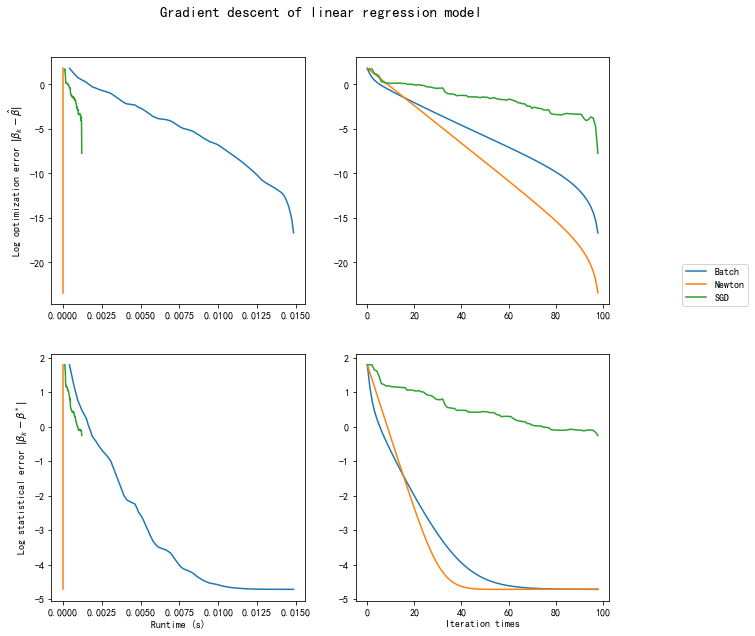

In [ ]:
gradientDescent(type='linear')

## visualize gradient descent in 2-D

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def f(X, y, beta):
    """MSE"""
    return np.linalg.norm(X@beta - y)**2/X.shape[0]

def grad(X, y, beta):
    """Returns gradient of a linear function
    """
    return X.T @ (X @ beta - y)/X.shape[0]


def stochastic_grad(X, y, beta):
    """return a stochastic gradient (analytical)"""
    # pick a random index
    i = np.random.randint(0, X.shape[0])
    return X[i] * (X[i] @ beta - y[i])

def hess(X):
    """Returns a Hessian matrix of linear function"""
    return X.T @ X /X.shape[0]

def batch(X, y, beta0, step_size=0.001, num_iters=10):
    """Batch gradient descent
       Returns weight of last update
    """
    g0 = grad(X, y, beta0)  # initial gradient
    
    for _ in range(num_iters):    
        beta = beta0 - step_size * g0   # update weight
        plt.plot(beta[0], beta[1], 'ro')
        plt.plot([beta0[0],beta[0]],[beta0[1],beta[1]],'ro-')
        beta0 = beta   
        g0 = grad(X, y, beta0)  
            
    return beta0


def newton(X, y, beta0, step_size=0.001, num_iters=10):
    """Newton's gradient descent"""
    g0 = grad(X, y, beta0)  # initial gradient
    
    for _ in range(num_iters):    
        beta = beta0 - step_size * np.linalg.inv(hess(X)) @ g0   # update weight
        plt.plot(beta[0], beta[1], 'bo')
        plt.plot([beta0[0],beta[0]],[beta0[1],beta[1]],'bo-')
        beta0 = beta   
        g0 = grad(X, y, beta0)  
            
    return beta0


def sgd(X, y, beta0, step_size=0.001, num_iters=10):
    """stocastic gradient descent"""
    g0 = stochastic_grad(X, y, beta0)  # initial gradient
    
    for _ in range(num_iters):    
        beta = beta0 - step_size * g0   # update weight
        plt.plot(beta[0], beta[1], 'go')
        plt.plot([beta0[0],beta[0]],[beta0[1],beta[1]],'go-')
        beta0 = beta   
        g0 = stochastic_grad(X, y, beta0)  
            
    return beta0

Text(0, 0.5, '$X_2$')

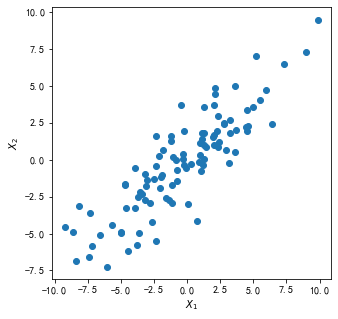

In [ ]:
### data
n=100
p=2 # 2 features
u=np.array([[1,1],[1,-1]])

X = np.random.randn(n,p)*np.array([4,1])@u 
betastar = np.random.randn(2)
y = X@betastar + 0.1*np.random.randn(n)

# 2 features are highly correlated
plt.figure(figsize=[5,5])
plt.scatter(X[:,0], X[:,1])
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")

# betahat = np.linalg.inv(X.T @ X) @ X.T @ y

# gradient of betahat should be zero
# grad(X, y, betahat), stochastic_grad(X, y, betahat)

loss decreases fastest in the direction that is vertical to level curve

Text(0.6, 0.6, 'End (-0.385, 1.883)')

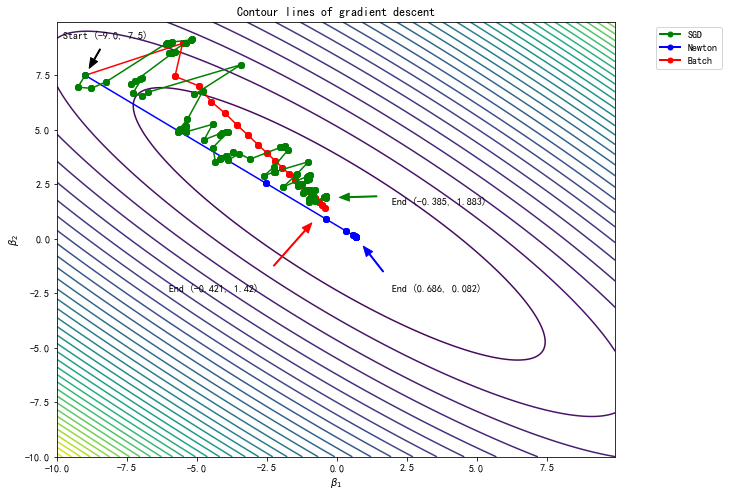

In [ ]:
fig, ax = plt.subplots(figsize=[10,8])

x = np.arange(-10,10,0.05)  # shape (400,)
# 等高线，值为MSE The height values  (400, 400)
z = np.array([f(X, y, np.array([a,b])) for a in x for b in x]).reshape((x.shape[0],x.shape[0]))
plt.contour(x, x, z, levels=50)

# initial weight
beta0 = np.array([-9,7.5])
beta_batch = batch(X, y, beta0, step_size=1.6/30,num_iters=20)
beta_newton = newton(X, y, beta0, step_size=20/30,num_iters=20)
beta_sgd = sgd(X, y, beta0, step_size=0.01,num_iters=100)

legend_elements = [Line2D([0], [0], marker='o', color='g', lw=2, 
                     markerfacecolor='g', markersize=5,label='SGD'),

                   Line2D([0], [0], marker='o', color='b', lw=2,
                          markerfacecolor='b', markersize=5, label='Newton'),

                   Line2D([0], [0], marker='o', color='r', lw=2,
                          markerfacecolor='r', markersize=5, label='Batch')]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.2, 1))

plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.title("Contour lines of gradient descent")

ax.annotate(text=f'Start {tuple(beta0)}', xy=beta0, xycoords='data',
            xytext=(0.01, 0.98), textcoords='axes fraction',
            va='top', ha='left',
            arrowprops=dict(width=1, headlength=10, headwidth=8, color='black',  shrink=0.2))


ax.annotate(text=f'End {tuple(np.round(beta_newton, 3))}', xy=beta_newton, xycoords='data',
            xytext=(0.6, 0.4), textcoords='axes fraction',
            va='top', ha='left',
            arrowprops=dict(width=1, headlength=10, headwidth=8, color='blue',  shrink=0.2))

ax.annotate(text=f'End {tuple(np.round(beta_batch, 3))}', xy=beta_batch, xycoords='data',
            xytext=(0.2, 0.4), textcoords='axes fraction',
            va='top', ha='left',
            arrowprops=dict(width=1, headlength=10, headwidth=8, color='red', shrink=0.2))

ax.annotate(text=f'End {tuple(np.round(beta_sgd, 3))}', xy=beta_sgd, xycoords='data',
            xytext=(0.6, 0.6), textcoords='axes fraction',
            va='top', ha='left',
            arrowprops=dict(width=1, headlength=10, headwidth=8, color='green', shrink=0.2))


## batch gradient descent

- gradient:

$$
\nabla f\left ( \beta  \right )=\frac{1}{n}X^{T}\left ( X\beta -\mathbf{y} \right )=\frac{1}{n}\sum_{i=1}^n [\mathbf{\mathbf{x_i}}(\mathbf{\mathbf{x_i}}^T\beta-\mathbf{y}_i)]
$$

- the $j^{th}$ entry of gradient:

$$
\frac{1}{n}\sum_{i=1}^n [\mathbf{x}_i]_j (\mathbf{x}_i^T\beta -\mathbf{y}_i)
$$

- weight update:

$$
\begin{align}
\beta_k
&=\beta_{k-1}-\eta\nabla f(\beta_{k-1})\\[1em]

&=\beta_{k-1}-\eta \frac{1}{n}X^{T}\left ( X\beta_{k-1} -\mathbf{y} \right )\\[1em]

&=\beta_{k-1}-\eta \frac{1}{n}\sum_{i=1}^n \mathbf{\mathbf{x_i}}(\mathbf{\mathbf{x_i}}^T\beta_{k-1}-\mathbf{y}_i)\\[1em]
\end{align}
$$

## Newton's

- gradient:

$$
\nabla f\left ( \beta  \right )=\frac{1}{n}X^{T}\left ( X\beta -\mathbf{y} \right )=\frac{1}{n}\sum_{i=1}^n \mathbf{\mathbf{x_i}}(\mathbf{\mathbf{x_i}}^T\beta-\mathbf{y}_i)
$$

- Hessian: a square matrix $\in \mathbb{R}^{p \times p}$

$$
H(f(\beta))=\frac{1}{n}X^TX=\frac{1}{n}\sum_{i=1}^n\mathbf{x}_i\mathbf{x}_i^T
$$

- the ${i,j}^{th}$ entry of Hessian:

$$
\left[H(f(\beta))\right]_{ij}=\frac{1}{n}\sum_{k=1}^n[\mathbf{x}_k]_{i}[\mathbf{x}_k]_{j}
$$

- weight update:

$$
\begin{align}
\beta_{k} 
&= \beta_{k-1} - [H (f(\beta_k))]^{-1} \nabla f(\beta_{k-1})\\[1em]

&=\beta_{k-1}-\left(\frac{1}{n}X^TX \right)^{-1} \left[\frac{1}{n}X^{T}( X\beta_{k-1} -\mathbf{y} ) \right]\\[1em]

&=\beta_{k-1}-[\beta_{k-1}-(X^TX)^{-1}X^T\mathbf{y}]\\[1em]

&=(X^TX)^{-1}X^T\mathbf{y}\\[1em]
\end{align}
$$

Newton's method for **quadratic function $f$ solving in 1 step**

$\beta_{k}=(X^TX)^{-1}X^Ty$ means Newton's for linear regression can find solution by **only 1 iteration**

## SGD

- gradient for sample $J$:

$$
\nabla f_{J}(\beta)=\mathbf{x}_{J}(\mathbf{x}_{J}^T\beta-\mathbf{y}_{J})
$$

- weight update:

$$
\begin{align}
\beta_k
&=\beta_{k-1}-\eta\nabla f_{J_k}(\beta_{k-1})\\[1em]
&=\beta_{k-1}-\eta\mathbf{x}_{J_k}(\mathbf{x}_{J_k}^T\beta_{k-1}-\mathbf{y}_J)
\end{align}
$$


# Logistic regression

input matrix $X \in \mathbb{R}^{n \times m}$ , $n$ observations, $m$ features, with $i^{th}$ row $\mathbf{x}_i^T\in \mathbb{R}^{1\times m}$

$X_{(i,j)}$ or $[\mathbf{x}_i^T]_{(j)}$ is an observation in $i^{th}$ row and $j^{th}$ column

weight vector $\beta \in \mathbb{R}^m$ with $i^{th}$ entry $\beta_i$

response vector label $\mathbf{y} \in  \mathbb{R}^n$ with $i^{th}$ entry $\mathbf{y_i}\in \left\{0,1\right\}$

empirical risk function of $\beta$: 

$$
f(\beta)=\frac{1}{n} \sum_{i=1}^n  \ln [1+\textrm{exp}(\beta^T \mathbf{x_i})]-\mathbf{y_i} \beta^T \mathbf{x_i}
$$ 

we try to minimize it to find the optimal $\beta$

$$
\hat{\beta }=\underset{\beta}{\arg \min}f\left ( \beta  \right )
$$


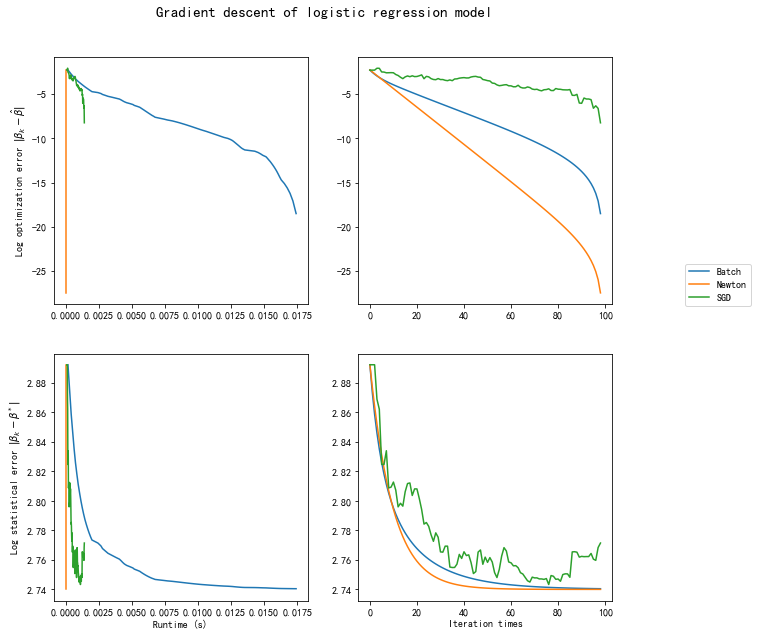

In [ ]:
gradientDescent('logistic')

## batch gradient descent

- gradient:

$$
\nabla f\left ( \beta  \right )=\frac{1}{n}X^{T}\left ( \mathbf{p} -\mathbf{y} \right )=\frac{1}{n}\sum_{i=1}^n \mathbf{\mathbf{x_i}}(\mathbf{p_i}-\mathbf{y_i})
$$

**Note, compared with linear regression, just change $x^T\beta$ to $p$**

the $i^{th}$ entry of gradient:

$$
\sum_{k=1}^n [\mathbf{x_k}]_i (\mathbf{p}_k -\mathbf{y}_k)
$$

- weight update:

$$
\begin{align}
\beta_k
&=\beta_{k-1}-\eta\nabla f(\beta_{k-1})\\[1em]

&=\beta_{k-1}-\eta \frac{1}{n} X^T( \mathbf{p} -\mathbf{y})\\[1em]

&=\beta_{k-1}-\eta\frac{1}{n}\sum_{i=1}^n \mathbf{\mathbf{x_i}}(\mathbf{p_i}-\mathbf{y_i})\\[1em]
\end{align}
$$

- conditional probability $\mathbf{p} \in \mathbb{R}^n$ is a vector, where the $i$ th entry $\mathbf{p_i} \in  (0, 1)$ is an output of sigmoid function

$$
\mathbf{p_i}=P(\mathbf{y_i}=1 | \mathbf{x_i}) = \frac{\textrm{exp}(\mathbf{x_i}^T \beta)}{1+\textrm{exp}(\mathbf{x_i}^T \beta)}=\frac{1}{1+\textrm{exp}(-\mathbf{x_i}^T \beta)}
$$

derivative of $\mathbf{p_i}$ with respect to $\beta$ is:

$$
\frac{\partial \mathbf{p_i}}{\partial \beta}=\mathbf{p_i}(1-\mathbf{p_i})\mathbf{x_i}
$$

partial derivative of $\mathbf{p_i}$ with respect to $j$ th entry of $\beta$ is:

$$
\frac{\partial \mathbf{p_i}}{\partial [\beta]_j}=\mathbf{p_i}(1-\mathbf{p_i})\left [ \mathbf{x_i} \right ]_j
$$

## Newton's

- gradient:

$$
\nabla f\left ( \beta  \right )=\frac{1}{n}X^{T}\left ( \mathbf{p} -\mathbf{y} \right )=\frac{1}{n}\sum_{i=1}^n \mathbf{\mathbf{x_i}}(\mathbf{p_i}-\mathbf{y_i})
$$

- Hessian: a square matrix $\in \mathbb{R}^{m \times m}$

$$
H(f(\beta))=\frac{1}{n}X^TSX=\frac{1}{n}\sum_{i=1}^n (\mathbf{x_i}\mathbf{x_i}^T)\mathbf{p_i}(1-\mathbf{p_i})
$$

$S \in \mathbb{R}^{n \times n}$ is a diagonal matrix, where the $(i,i)$ th diagonal element is $\mathbf{p_i}(1-\mathbf{p_i})$

$$
S= \text{diag}\left[\mathbf{p_i}(1-\mathbf{p_i})\right]
$$

the ${i,j}^{th}$ entry of Hessian:

$$
\left[H(f(\beta))\right]_{ij}=\frac{1}{n}\sum_{k=1}^n [\mathbf{x_k}]_i p_k(1-p_k) [\mathbf{x_k}]_j
$$

- weight update:

$$
\begin{align}
\beta_{k} 

&= \beta_{k-1} - [H (f(\beta_{k-1}))]^{-1} \nabla f(\beta_{k-1})\\[1em]

&=\beta_{k-1}-(X^TSX)^{-1}X^{T}\left ( \mathbf{p} -\mathbf{y} \right )\\[1em]
\end{align}
$$


## SGD

- gradient for sample $J_k$:

$$
\nabla f_{J_k}(\beta_{k-1})=\mathbf{x}_{J_k}\left(\mathbf{p}_{J_k}-\mathbf{y}_{J_k}\right)
$$

- weight update:

$$
\begin{align}
\beta_k
&=\beta_{k-1}-\eta\nabla f_{J_k}(\beta_{k-1})\\[1em]

&=\beta_{k-1}-\eta\mathbf{x}_{J_k}\left(\mathbf{p}_{J_k}-\mathbf{y}_{J_k}\right)\\[1em]
\end{align}
$$


# generalized linear model

modeling choice $\gamma=X\beta$

empirical risk function

$$
f(\beta)=\frac{1}{n}\sum_{i=1}^nA(\left \langle \mathbf{x_i},\beta \right \rangle)-\mathbf{y_i}\left \langle \mathbf{x_i},\beta \right \rangle-\ln(h(\mathbf{y_i}))
$$

## batch gradient descent

- gradient:

$$
\begin{align}
\nabla f\left ( \beta  \right )
&=\frac{1}{n}X^{T}\left ( A'(X\beta) -\mathbf{y} \right )\\[1em]
&=\frac{1}{n}X^T \mathbf{e}\\[1em]
&=\frac{1}{n}\sum_{i=1}^n \mathbf{\mathbf{x_i}}(A'(\left \langle \mathbf{x_i},\beta \right \rangle)-\mathbf{y_i})\\[1em]
&=\frac{1}{n}\sum_{i=1}^n \mathbf{\mathbf{x_i}}(\mathbf{e_i}-\mathbf{y_i})\\[1em]
\end{align}
$$

vector $\mathbf{e} \in \mathbb{R}^n$ is error

$$
\mathbf{e}=A'(X\beta)-\mathbf{y}
$$

error of $i$ th observation is 

$$
\mathbf{e}_i=A'(\left \langle \mathbf{x_i},\beta \right \rangle)-\mathbf{y_i}
$$

- weight update:

$$
\begin{align}
\beta_k

&=\beta_{k-1}-\eta\nabla f(\beta_{k-1})\\[1em]

&=\beta_{k-1}-\eta \frac{1}{n} X^T [ A'(X\beta_{k-1}) -\mathbf{y}]\\[1em]

&=\beta_{k-1}-\eta\frac{1}{n}\sum_{i=1}^n \mathbf{\mathbf{x_i}}\left[A'(\left \langle \mathbf{x_i},\beta_{k-1} \right \rangle)-\mathbf{y_i}\right]\\[1em]
\end{align}
$$

## Newton's

- gradient:

$$
\begin{align}
\nabla f\left ( \beta  \right )
&=\frac{1}{n}X^{T}\left ( A'(X\beta) -\mathbf{y} \right )\\[1em]
&=\frac{1}{n}X^T \mathbf{e}\\[1em]
&=\frac{1}{n}\sum_{i=1}^n \mathbf{\mathbf{x_i}}(A'(\left \langle \mathbf{x_i},\beta \right \rangle)-\mathbf{y_i})\\[1em]
&=\frac{1}{n}\sum_{i=1}^n \mathbf{\mathbf{x_i}}(\mathbf{e_i}-\mathbf{y_i})\\[1em]
\end{align}
$$

- Hessian

$$
H(f(\beta))=\frac{1}{n}A''(X\beta) X^TX=\frac{1}{n}\sum_{i=1}^nA''(\left \langle \mathbf{x_i},\beta \right \rangle)\ \mathbf{x_i} \mathbf{x_i}^T
$$

- weight update:

$$
\begin{align}
\beta_{k} 

&= \beta_{k-1} - [H f(\beta_{k-1})]^{-1} \nabla f(\beta_{k-1})\\[1em]

&=\beta_{k-1}-\left[A''(X\beta) X^TX\right]^{-1} X^{T}\left ( A'(X\beta) -\mathbf{y} \right )\\[1em]
\end{align}
$$


## stochastic

- gradient for sample $J_k$:

$$
\nabla f_{J_k}(\beta_{k-1})=\mathbf{x}_{J_k} [A'\left(\left \langle \mathbf{x}_{J_k},\beta_{k-1} \right \rangle \right)-\mathbf{y}_{J_k}]
$$

- weight update:

$$
\begin{align}
\beta_k
&=\beta_{k-1}-\eta\nabla f_{J_k}(\beta_{k-1})\\[1em]

&=\beta_{k-1}-\eta\mathbf{x}_{J_k} [A'\left(\left \langle \mathbf{x}_{J_k},\beta_{k-1} \right \rangle \right)-\mathbf{y}_{J_k}]
\end{align}
$$


if $y_J=1$, $A'\left(\left \langle \mathbf{x}_{J_k},\beta_{k-1} \right \rangle \right)< 1$, next iteration $\beta_k$ will be pushed to $x_J$ direction

if $y_J=0$, $A'\left(\left \langle \mathbf{x}_{J_k},\beta_{k-1} \right \rangle \right) > 0$, next iteration $\beta_k$ will be pushed away from $x_J$ direction